# E-Commerce Case Study

### This notebook focuses on the data analysis of e-commerce platform. In the initial stage, it peforms sales trend analysis. Then, it analyzes customer data. Lastly, it performs customer segmentation using KMeans algorithm and provides some meaningful insights about each segment.

In [1]:
#installing all required libraries

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from datetime import datetime, timedelta

In [2]:
#loading the data

customers = pd.read_csv('customers_dataset.csv')
order_items = pd.read_csv('order_items_dataset.csv')
orders = pd.read_csv('orders_dataset.csv')
product_category = pd.read_csv('product_category_name_translation.csv')
products = pd.read_csv('products_dataset.csv')

## Data Preprocessing

In [3]:
#changing product category names to english and combining dimensions of products into 'volume_cm' feature

products_eng = products.merge(product_category, left_on='product_category_name', right_on='product_category_name').drop(columns=['product_category_name'])

products_eng.drop(columns=['product_name_lenght','product_description_lenght'], inplace=True)

products_eng['volume_cm'] = products_eng['product_length_cm']*products_eng['product_height_cm']*products_eng['product_width_cm']

products_eng.drop(columns=['product_length_cm','product_height_cm','product_width_cm'], inplace=True)

products_eng

,product_id,product_photos_qty,product_weight_g,product_category_name_english,volume_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,1.0,225.0,perfumery,2240.0
1,6a2fb4dd53d2cdb88e0432f1284a004c,2.0,400.0,perfumery,2700.0
2,0d009643171aee696f4733340bc2fdd0,1.0,422.0,perfumery,6048.0
3,b1eae565a61935e0011ee7682fef9dc9,2.0,267.0,perfumery,3757.0
4,8da90b37f0fb171b4877c124f965b1f6,3.0,377.0,perfumery,3510.0
...,...,...,...,...,...
32323,13b25797ad1e6d6c7cd3cbeb35f8ee7a,1.0,18250.0,furniture_mattress_and_upholstery,15625.0
32324,dc36a7859b743d8610a2bbbaea26ece9,2.0,2500.0,furniture_mattress_and_upholstery,18081.0
32325,107fde0930956120d1e13dd1062fbb46,1.0,30000.0,furniture_mattress_and_upholstery,262800.0
32326,726b4e18f00255e2e63491bcba3f60b8,1.0,1700.0,furniture_mattress_and_upholstery,70000.0


In [4]:
#joining all tables into one

order_items_products_eng = order_items.merge(products_eng, left_on='product_id', right_on='product_id')

cust_order = customers.merge(orders, left_on='customer_id', right_on='customer_id')

cust_order = cust_order[cust_order['order_status']=='delivered']

final_df = cust_order.merge(order_items_products_eng,left_on='order_id', right_on='order_id')

In [5]:
#dropping all null values

final_df.dropna(inplace=True)

In [6]:
#changing format of all time related columns to datetime

final_df['order_purchase_timestamp'] = pd.to_datetime(final_df['order_purchase_timestamp'])

final_df['order_approved_at'] = pd.to_datetime(final_df['order_approved_at'])

final_df['order_delivered_carrier_date'] = pd.to_datetime(final_df['order_delivered_carrier_date'])

final_df['order_delivered_customer_date'] = pd.to_datetime(final_df['order_delivered_customer_date'])

final_df['order_estimated_delivery_date'] = pd.to_datetime(final_df['order_estimated_delivery_date'])

In [7]:
#calculating 'total_revenue' column
final_df['total_revenue'] = final_df['order_item_id']*final_df['price']

#calculating Year-Month column
final_df['monthly_order_purchase_time'] = final_df["order_purchase_timestamp"].apply(lambda x: x.strftime('%Y-%m'))

In [8]:
#creating a grouped table and calculating monthly growth of total revenue

MoM = final_df.groupby(["monthly_order_purchase_time"]).sum()

MoM['Last_Month'] = np.roll(MoM['total_revenue'],1)

MoM['Growth'] = (MoM['total_revenue']/MoM['Last_Month'])-1

In [9]:
#creating a grouped table for order level analysis
order_items = final_df.groupby('order_id').agg(
    
    {

        'product_id':'count',

        'seller_id': pd.Series.nunique, #number of unique sellers for each order_id

        'total_revenue': 'sum',  

        'shipping_limit_date': 'count'  

    }

)

order_items=order_items.reset_index()

#renaming columns of order_items table
order_items.rename(columns = {'product_id':'product_counts',

                              'seller_id':'seller_counts',

                              'total_revenue': 'order_value',

                              'shipping_limit_date':'order_count'

                              }, inplace = True)

order_items.head()

,order_id,product_counts,seller_counts,order_value,order_count
0,00010242fe8c5a6d1ba2dd792cb16214,1,1,58.90,1
1,00018f77f2f0320c557190d7a144bdd3,1,1,239.90,1
2,000229ec398224ef6ca0657da4fc703e,1,1,199.00,1
3,00024acbcdf0a6daa1e931b038114c75,1,1,12.99,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1,199.90,1


In [11]:
#creating a grouped table for customer level analysis

customer_orders = pd.merge(cust_order,order_items, on='order_id',how='inner')

customer_shopping = customer_orders.groupby(['customer_unique_id','customer_city']).agg(

    {

         'seller_counts': 'sum',

         'order_value': 'sum',

         'order_count': 'sum' ,

         'product_counts': 'sum',

         'order_approved_at' : [np.min, np.max],

    }

)

customer_shopping=customer_shopping.reset_index()

customer_shopping.head()

customer_unique_id customer_city seller_counts order_value  \
                                                            sum         sum   
0  0000366f3b9a7992bf8c76cfdf3221e2       cajamar             1      129.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f        osasco             1       18.90   
2  0000f46a3911fa3c0805444483337064      sao jose             1       69.00   
3  0000f6ccb0745a6a4b88665a16c9f078         belem             1       25.99   
4  0004aac84e0df4da2b147fca70cf8255      sorocaba             1      180.00   

  order_count product_counts    order_approved_at                       
          sum            sum                 amin                 amax  
0           1              1  2018-05-10 11:11:18  2018-05-10 11:11:18  
1           1              1  2018-05-07 18:25:44  2018-05-07 18:25:44  
2           1              1  2017-03-10 21:05:03  2017-03-10 21:05:03  
3           1              1  2017-10-12 20:49:17  2017-10-12 20:49:17  
4           1              1  2017-11-14 20:06:52  2017-11-14 20:06:52

In [12]:
#renaming column names

customer_shopping.columns=['customer_unique_id','city','seller_counts', 'order_value', 'order_count','product_counts','first_order_date','last_order_date']


In [13]:
#deciding whether customer is active or inactive based on last order date
from dateutil.relativedelta import relativedelta

customer_shopping['last_order_date'] = pd.to_datetime(customer_shopping['last_order_date'])

#customer is active if his last order date is within the last 6 months
last_date = customer_shopping.last_order_date.max()-relativedelta(months=6)
customer_shopping['Status'] = customer_shopping['last_order_date'].apply(lambda x: 'Active' if x>last_date else 'Inactive')

In [14]:
#calculating the month when customer placed his first order

customer_shopping['first_order_date'] = pd.to_datetime(customer_shopping['first_order_date'])

customer_shopping['first_order_month'] = customer_shopping["first_order_date"].apply(lambda x: x.strftime('%Y-%m'))

In [15]:
#saving tables

final_df = final_df.reset_index(drop=True)
customer_shopping = customer_shopping.reset_index(drop=True)

final_df.to_csv('merged_df.csv')
customer_shopping.to_csv('customer_shopping.csv')
MoM.to_csv('monthly_df.csv')

## Visual Analytics

<AxesSubplot:ylabel='total_revenue'>

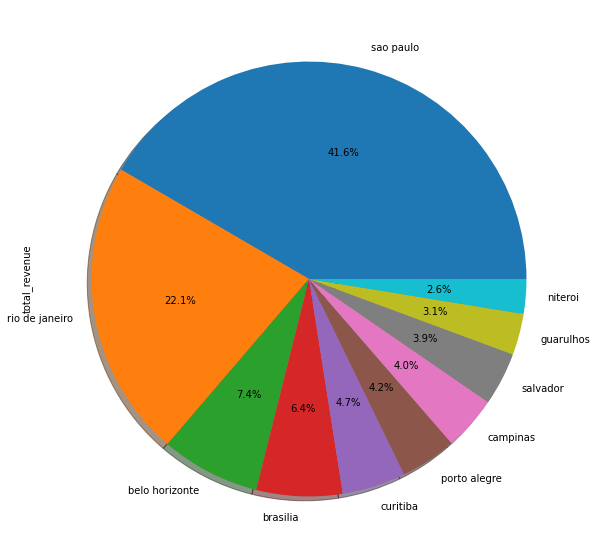

In [16]:
#Total revenue across top 10 cities

top_cities = final_df.groupby(['customer_city'])['total_revenue'].sum()

top_cities.sort_values(ascending=False).head(10).plot(kind='pie',autopct='%1.1f%%', shadow=True, figsize=(10,10))

<AxesSubplot:ylabel='total_revenue'>

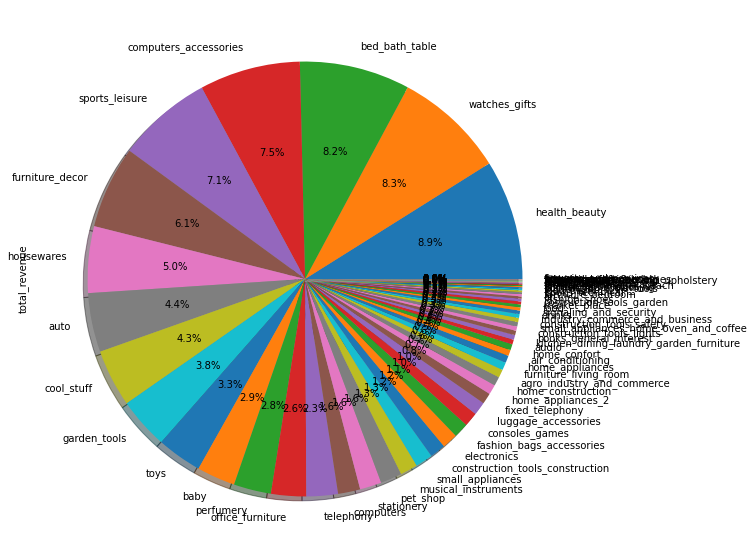

In [29]:
#15 categories account for more than 80 percent of revenue

top_categories = final_df.groupby(['product_category_name_english'])['total_revenue'].sum()

top_categories.sort_values(ascending=False).plot(kind='pie',autopct='%1.1f%%', shadow=True, figsize=(10,10))

<AxesSubplot:xlabel='order_purchase_timestamp'>

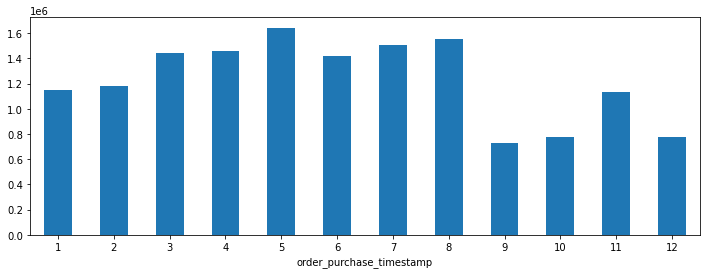

In [18]:
#Monthly Total Revenue

fig, axs = plt.subplots(figsize=(12, 4))

final_df.groupby(final_df["order_purchase_timestamp"].dt.month)["total_revenue"].sum().plot(kind='bar', rot=0, ax=axs)

<AxesSubplot:xlabel='order_purchase_timestamp'>

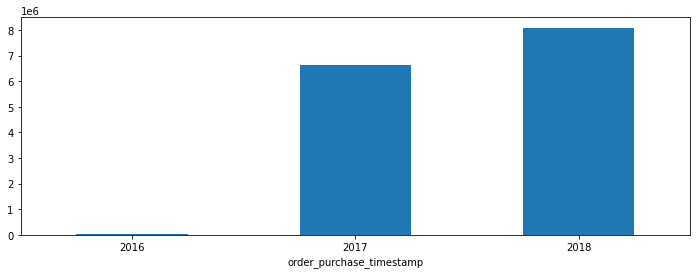

In [19]:
#Yearly Total Revenue

fig, axs = plt.subplots(figsize=(12, 4))

final_df.groupby(final_df["order_purchase_timestamp"].dt.year)["total_revenue"].sum().plot(kind='bar', rot=0, ax=axs)

<AxesSubplot:xlabel='monthly_order_purchase_time'>

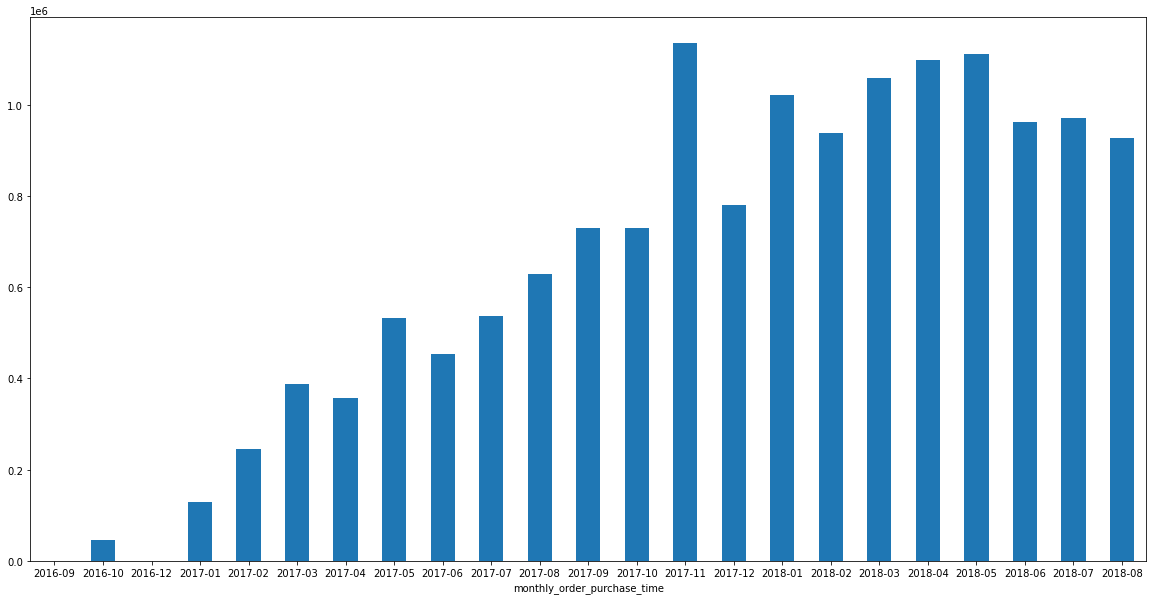

In [20]:
#Year-Month Total Revenue

fig, axs = plt.subplots(figsize=(20, 10))

final_df.groupby(final_df["monthly_order_purchase_time"])["total_revenue"].sum().plot(kind='bar',rot=0, ax=axs)

<AxesSubplot:xlabel='customer_city'>

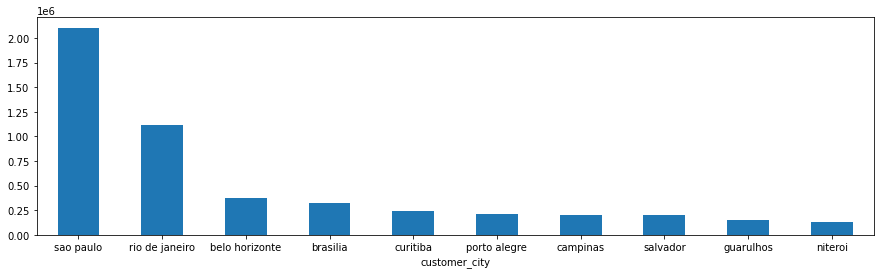

In [21]:
#Total Revenue by top 10 cities

fig, axs = plt.subplots(figsize=(15, 4))

final_df.groupby(final_df["customer_city"])["total_revenue"].sum().sort_values(ascending=False).head(10).plot(kind='bar', rot=0, ax=axs)

<AxesSubplot:xlabel='monthly_order_purchase_time'>

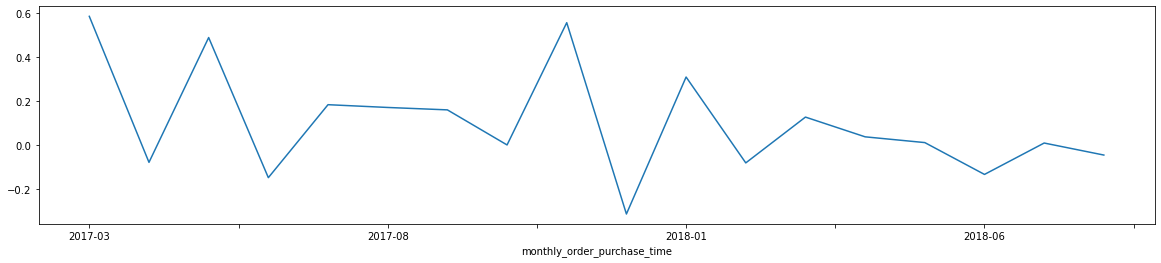

In [22]:
#Monthly growth percentage

fig, axs = plt.subplots(figsize=(20, 4))

MoM["Growth"][5:].plot()

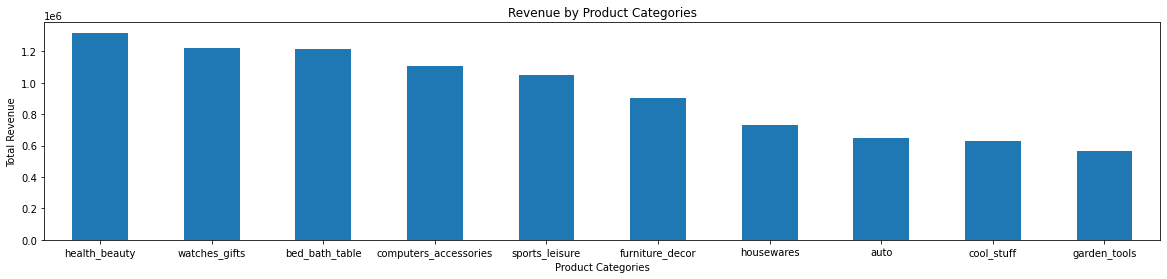

In [23]:
#Revenue for top 10 categories

fig, axs = plt.subplots(figsize=(20, 4))

final_df.groupby(['product_category_name_english'])["total_revenue"].sum().sort_values(ascending=False).head(10).plot(kind='bar', rot=0, ax=axs)

plt.xlabel('Product Categories')

plt.ylabel('Total Revenue')

plt.title('Revenue by Product Categories')

plt.show()

<AxesSubplot:xlabel='Status'>

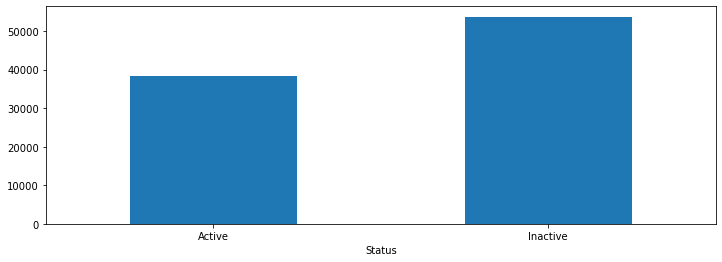

In [24]:
#Number of Active and Inactive customers

fig, axs = plt.subplots(figsize=(12, 4))

customer_shopping.groupby(['Status'])["customer_unique_id"].count().plot(kind='bar', rot=0, ax=axs)

<AxesSubplot:title={'center':'New Customers by Month Year'}, xlabel='first_order_month', ylabel='Number of Customers Joined'>

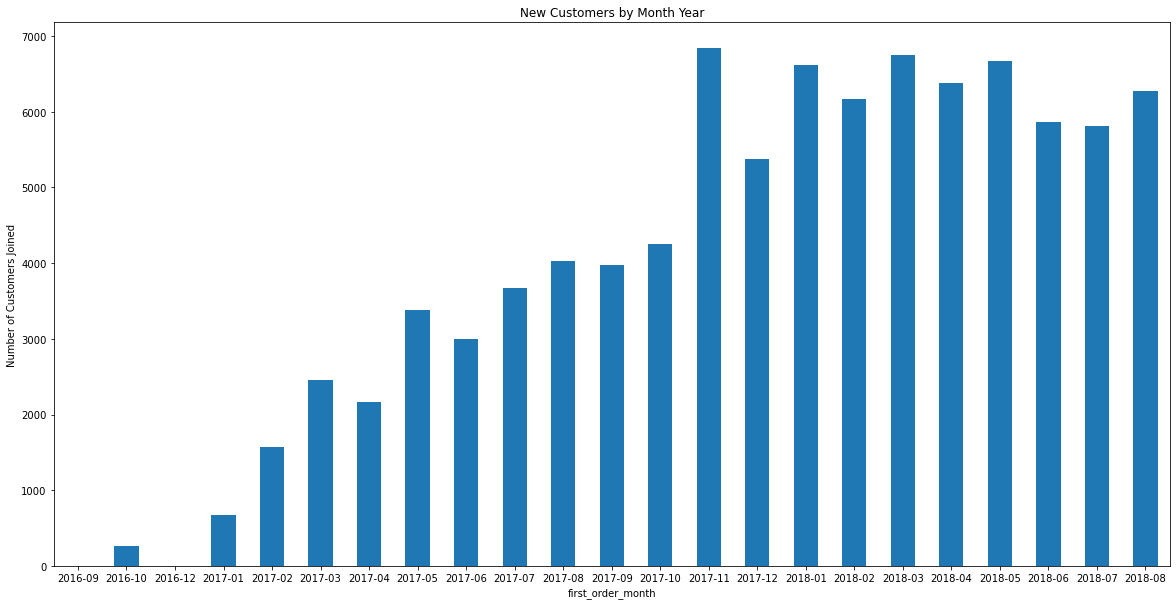

In [25]:
#Newly joined customers analysis

fig, axs = plt.subplots(figsize=(20, 10))

plt.xlabel('Month Year')

plt.ylabel('Number of Customers Joined')

plt.title('New Customers by Month Year')

customer_shopping.groupby(customer_shopping["first_order_month"])["customer_unique_id"].count().plot(kind='bar',rot=0, ax=axs)

### Customer Segmentation

In [31]:
#creating table with unique customers at each row

customers = pd.DataFrame({'customer_id':final_df['customer_id'].unique()})

In [32]:
#creating columns with top 15 category names and initializing them as 0

customers[top_categories.sort_values(ascending=False).head(15).index] = 0

In [33]:
customers

,customer_id,health_beauty,watches_gifts,bed_bath_table,computers_accessories,sports_leisure,furniture_decor,housewares,auto,cool_stuff,garden_tools,toys,baby,perfumery,office_furniture,telephony
0,06b8999e2fba1a1fbc88172c00ba8bc7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18955e83d337fd6b2def6b18a428ac77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4e7b3e00288586ebd08712fdd0374a03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,b2b6027bc5c5109e529d4dc6358b12c3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95099,17ddf5dd5d51696bb3d7c6291687be6f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95100,e7b71a9017aa05c9a7fd292d714858e8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95101,5e28dfe12db7fb50a4b2f691faecea5e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95102,56b18e2166679b8a959d72dd06da27f9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
#filling the categories with total revenue from each customer

from tqdm import tqdm
for index in tqdm(range(len(final_df))):
    customerID = final_df.loc[index,'customer_id']
    product_category = final_df.loc[index,'product_category_name_english']
    if product_category in customers.columns:
        product_price = final_df.loc[index,'total_revenue']
        customers_table_index = customers[customers['customer_id']==customerID].index[0]
        customers.loc[customers_table_index, product_category] += product_price

100%|██████████| 108614/108614 [10:48<00:00, 167.37it/s]


In [35]:
#creating and filling new columns with 0

customers['PurchaseCount'] = 0
customers['PurchaseMin'] = 0
customers['PurchaseMax'] = 0
customers['PurchaseMean'] = 0
customers['PurchaseSum'] = 0
customers['FreightMean'] = 0
customers['FreightSum'] = 0
customers['MajorCity'] = 0
customers.head()

,customer_id,health_beauty,watches_gifts,bed_bath_table,computers_accessories,sports_leisure,furniture_decor,housewares,auto,cool_stuff,...,office_furniture,telephony,PurchaseCount,PurchaseMin,PurchaseMax,PurchaseMean,PurchaseSum,FreightMean,FreightSum,MajorCity
0,06b8999e2fba1a1fbc88172c00ba8bc7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124.99,0.0,0,0,0,0,0,0,0,0
1,18955e83d337fd6b2def6b18a428ac77,0.0,0.0,0.0,0.0,0.0,0.0,289.0,0.0,0.0,...,0.00,0.0,0,0,0,0,0,0,0,0
2,4e7b3e00288586ebd08712fdd0374a03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,139.94,0.0,0,0,0,0,0,0,0,0
3,b2b6027bc5c5109e529d4dc6358b12c3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,149.94,0.0,0,0,0,0,0,0,0,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0,0,0,0,0,0,0,0


In [36]:
#for each customr id in a customers table, we try to fill out columns

from tqdm import tqdm
for index in tqdm(range(len(customers))):
    customerID = customers.loc[index,'customer_id']
    history = final_df[final_df['customer_id']==customerID]['total_revenue']
    delivery = final_df[final_df['customer_id']==customerID]['freight_value']
    city = final_df[final_df['customer_id']==customerID]['customer_city'].iloc[0]
    if (city in top_cities.sort_values(ascending=False).head(2).index):
        customers.loc[index,'MajorCity'] = 1
    else:
        customers.loc[index,'MajorCity'] = 0
    customers.loc[index,'PurchaseCount'] = history.count()
    customers.loc[index,'PurchaseMin'] = history.min()
    customers.loc[index,'PurchaseMax'] = history.max()
    customers.loc[index,'PurchaseMean'] = history.mean()
    customers.loc[index,'PurchaseSum'] = history.sum()
    customers.loc[index,'FreightMean'] = delivery.mean()
    customers.loc[index,'FreightSum'] = delivery.sum()
    

100%|██████████| 95104/95104 [43:41<00:00, 36.27it/s] 


In [37]:
#focus only on major two cities

customers_major = customers[customers['MajorCity']==1]

In [38]:
customers_major

,customer_id,health_beauty,watches_gifts,bed_bath_table,computers_accessories,sports_leisure,furniture_decor,housewares,auto,cool_stuff,...,office_furniture,telephony,PurchaseCount,PurchaseMin,PurchaseMax,PurchaseMean,PurchaseSum,FreightMean,FreightSum,MajorCity
2,4e7b3e00288586ebd08712fdd0374a03,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,139.94,0.00,1,139.94,139.94,139.94,139.94,17.79,17.79,1
6,fd826e7cf63160e536e0908c76c3f441,0.0,0.0,0.0,14.99,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,1,14.99,14.99,14.99,14.99,7.78,7.78,1
10,5aa9e4fdd4dfd20959cad2d772509598,0.0,0.0,0.0,129.90,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,1,129.90,129.90,129.90,129.90,23.23,23.23,1
12,eabebad39a88bb6f5b52376faec28612,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,27.99,1,27.99,27.99,27.99,27.99,8.40,8.40,1
15,a7c125a0a07b75146167b7f04a7f8e98,0.0,0.0,0.0,0.00,0.0,0.0,0.0,119.9,0.0,...,0.00,0.00,1,119.90,119.90,119.90,119.90,17.03,17.03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95072,f6c6d3e1e20969a5eed982163f959719,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,1,99.90,99.90,99.90,99.90,21.14,21.14,1
95074,da37711b17efd5f2539e8196ab215f04,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,1,19.99,19.99,19.99,19.99,10.96,10.96,1
95085,821a7275a08f32975caceff2e08ea262,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,1,84.90,84.90,84.90,84.90,7.46,7.46,1
95086,c6ece8a5137f3c9c3a3a12302a19a2ac,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,24.99,1,24.99,24.99,24.99,24.99,7.78,7.78,1


In [39]:
from sklearn.preprocessing import StandardScaler
final_customers = customers_major.drop(columns='customer_id')
scaler = StandardScaler()
scaled_customers = scaler.fit_transform(final_customers)

In [40]:
scaled_customers = pd.DataFrame(scaled_customers, columns=final_customers.columns)
scaled_customers

,health_beauty,watches_gifts,bed_bath_table,computers_accessories,sports_leisure,furniture_decor,housewares,auto,cool_stuff,garden_tools,...,office_furniture,telephony,PurchaseCount,PurchaseMin,PurchaseMax,PurchaseMean,PurchaseSum,FreightMean,FreightSum,MajorCity
0,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,1.310324,-0.084395,-0.265625,0.124496,0.041815,0.082795,-0.021602,0.114088,-0.056918,0.0
1,-0.166406,-0.137219,-0.193426,0.013518,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,-0.576346,-0.537499,-0.575035,-0.262576,-0.716301,-0.664501,0.0
2,-0.166406,-0.137219,-0.193426,0.681831,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,0.068182,-0.004734,0.029937,-0.040965,0.565368,0.273276,0.0
3,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,0.806367,-0.265625,-0.503429,-0.477226,-0.506593,-0.237505,-0.664868,-0.626868,0.0
4,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,2.607588,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,0.012092,-0.051098,-0.022710,-0.060251,0.051042,-0.103049,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21298,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,-0.100087,-0.143825,-0.128005,-0.098822,0.391990,0.146418,0.0
21299,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,-0.548301,-0.514317,-0.548711,-0.252933,-0.452501,-0.471482,0.0
21300,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,-0.184222,-0.213371,-0.206976,-0.127750,-0.742846,-0.683924,0.0
21301,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,0.710894,-0.265625,-0.520256,-0.491135,-0.522387,-0.243291,-0.716301,-0.664501,0.0


In [41]:
from sklearn.cluster import KMeans
cluster_nums = [2,3,4,5,6,7,9,10,12,20,30,70]
scores = []
for cluster_num in tqdm(cluster_nums):
    kmeans = KMeans(cluster_num)
    kmeans.fit(scaled_customers)
    clusters = kmeans.predict(scaled_customers)
    scores.append(kmeans.inertia_)

100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


<AxesSubplot:xlabel='Clusters', ylabel='SSE'>

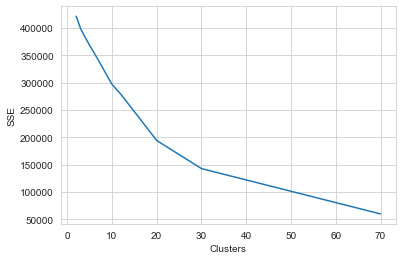

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.ylabel('SSE')
plt.xlabel('Clusters')
sns.lineplot(x=cluster_nums,y=scores)

In [43]:
kmeans = KMeans(5)
kmeans.fit(scaled_customers)

KMeans(n_clusters=5)

In [44]:
scaled_customers

,health_beauty,watches_gifts,bed_bath_table,computers_accessories,sports_leisure,furniture_decor,housewares,auto,cool_stuff,garden_tools,...,office_furniture,telephony,PurchaseCount,PurchaseMin,PurchaseMax,PurchaseMean,PurchaseSum,FreightMean,FreightSum,MajorCity
0,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,1.310324,-0.084395,-0.265625,0.124496,0.041815,0.082795,-0.021602,0.114088,-0.056918,0.0
1,-0.166406,-0.137219,-0.193426,0.013518,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,-0.576346,-0.537499,-0.575035,-0.262576,-0.716301,-0.664501,0.0
2,-0.166406,-0.137219,-0.193426,0.681831,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,0.068182,-0.004734,0.029937,-0.040965,0.565368,0.273276,0.0
3,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,0.806367,-0.265625,-0.503429,-0.477226,-0.506593,-0.237505,-0.664868,-0.626868,0.0
4,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,2.607588,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,0.012092,-0.051098,-0.022710,-0.060251,0.051042,-0.103049,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21298,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,-0.100087,-0.143825,-0.128005,-0.098822,0.391990,0.146418,0.0
21299,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,-0.548301,-0.514317,-0.548711,-0.252933,-0.452501,-0.471482,0.0
21300,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,-0.084395,-0.265625,-0.184222,-0.213371,-0.206976,-0.127750,-0.742846,-0.683924,0.0
21301,-0.166406,-0.137219,-0.193426,-0.073663,-0.156491,-0.147692,-0.139086,-0.094544,-0.12542,-0.086773,...,-0.048645,0.710894,-0.265625,-0.520256,-0.491135,-0.522387,-0.243291,-0.716301,-0.664501,0.0


<AxesSubplot:>

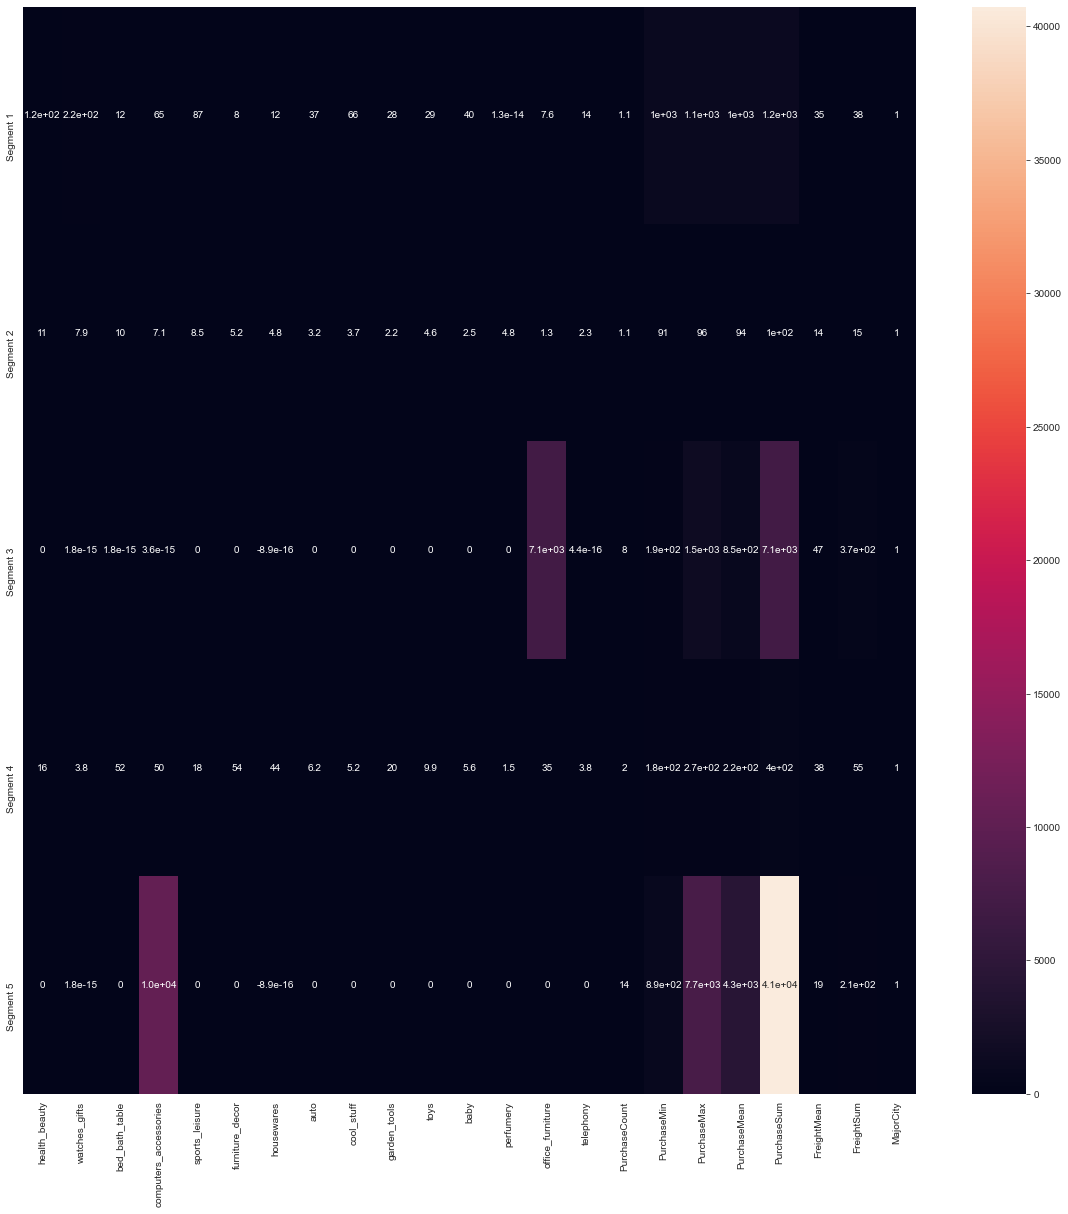

In [45]:
plt.figure(figsize=(20,20))
fig = sns.heatmap(scaler.inverse_transform(kmeans.cluster_centers_)[:,:23],annot=True,yticklabels=['Segment 1','Segment 2','Segment 3','Segment 4','Segment 5'],xticklabels=scaled_customers.columns)
fig

In [175]:
png = fig.get_figure()
png.savefig("Segmentation.png") 

In [46]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = final_customers.index.values
cluster_map['cluster'] = kmeans.labels_

In [47]:
cluster_map

,data_index,cluster
0,2,1
1,6,1
2,10,1
3,12,1
4,15,1
...,...,...
21298,95072,1
21299,95074,1
21300,95085,1
21301,95086,1
